### David Felipe Mora - CS
# Homework 1

* Related with the nature of the data, which conditions should meet matrices $A$ and $b$ to be solvable from the least squares perspective.

* Use a least squares for non-linear models adjust the bitcoin price and perform a prediction using the model to determine the future daily price a week ahead, compare with the actual values.

* Use least squares to determine the relationship between the bitcoin price and prices of three comodities namely, oil, silved and gold, during the last year.

* Solve the [point set registration problem](https://en.wikipedia.org/wiki/Point-set_registration). Hint (check: S. Umeyama, Least-Squares Estimation of Transformation Parameters Between Two Point Patterns, IEEE Trans. Pattern Anal. Mach. Intell., vol. 13, no. 4, 1991). Construct a GUI to test. (**Additional points**)

### 1. Least squares solution $A$ & $b$ conditions 
El problema de ajuste de datos mediante un modelo se puede resolver mediante la minimización de cuadrados de la siguiente forma:

$$\tilde{x} = \mbox{arg min}_{x} \| Ax - b \|_2^2$$ 
En donde la matriz $A$ "codifica" la naturaleza del modelo, $x$ son los parametros y $b$ son las predicciones.

Expandiendo esta expresion e igualando a cero el gradiente(para hallar el minimo de la función) llegamos a la ecuación normal: $$A^T A x = A^T b$$

Ahora bien, ¿Para que $A$ y $b$ tiene solución esta ecuación? 

Si las columnas de $A$ son linearmente independientes, entonces $(A^T A)^{-1}$ existe y la solución se puede calcular mediante $$x = (A^T A)^{-1} A^T b$$

Si las columnas de $A$ **NO** son linearmente independientes, entonces la ecuación se puede solucionar mediante descomposición ortogonal, por ejemplo usando descomposición QR o SVD.

Por lo tanto, las ecuaciones normales siempre tienen solución y el problema de los minimos cuadrados lineales es solucionable.

### 2. Linear Least Squares with Non Linear Model
Los datos de Bitcoin fueron tomados de [CryptoDataDownload](https://www.cryptodatadownload.com/data/gemini/).
 
Ahora se va a usar un modelo no lineal para explicar el precio del Bitcoin, especificamente se va modelar mediante un polinomio de grado 5:
$$f(x) = ax^5 + bx^4 + cx^3 + dx^2 + ex + o$$

Las librerias que vamos a usar son:

In [1]:
using CSV
using DataFrames
using Plots
using TimeSeries
using LinearAlgebra

Cargamos los datos del precio del Bitcoin

In [2]:
btc_ds = select(CSV.read("data/Gemini_BTCUSD_day.csv", DataFrame), Not(["Unix Timestamp", "Symbol", "Volume"]))
btc_ds.Date = broadcast(d -> Date(d[1:length(d)-9]), btc_ds.Date) # parse dates

n = 60 # last 60 days
btc_ds = btc_ds[1:n,:]; 

El dataset tiene la siguiente estructura:

In [3]:
first(btc_ds, 5)

,Date,Open,High,Low,Close
,Date,Float64,Float64,Float64,Float64
1,2022-03-17,41025.5,41471.6,40283.1,40592.0
2,2022-03-16,39177.7,41471.6,38950.0,41025.5
3,2022-03-15,38767.4,41702.9,38110.2,39177.7
4,2022-03-14,38167.6,39917.2,38130.8,38767.4
5,2022-03-13,39193.8,39309.1,37578.1,38167.6


Grafica de la serie de tiempo del Bitcoin

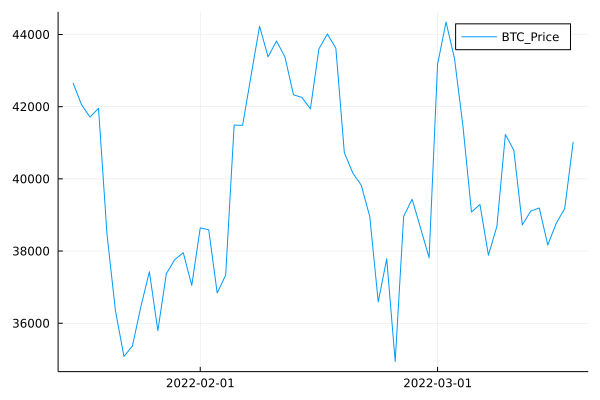

In [4]:
data = (date = btc_ds.Date, BTC_Price = btc_ds.Open)
ta = TimeArray(data; timestamp = :date, meta = "btc")
Plots.plot(ta)

**Linear Model**

Primero probemos un modelo lineal para ajustar los datos, para ello usamos la siguiente matriz de diseño `A`.

In [5]:
btc_prices = btc_ds.Open
A = [Array(1:n) ones(n,1)] 
b = Array(btc_prices);

Para cada forma de solucionar el sistema vamos a calcular el tiempo que requiere mediante `@time`

Calculo de la solución $ x = (A^T A)^{-1} A^T b$.

In [6]:
@time inv(transpose(A)*A)*transpose(A)*b

  1.224070 seconds (3.67 M allocations: 185.374 MiB, 3.00% gc time, 99.94% compilation time)


2-element Vector{Float64}:
   -15.582590441789307
 40317.0748418079

Solución de la ecuación normal $A^T A x = A^T b$ directamente usando el operador _backslash_ de Julia.

In [7]:
@time transpose(A)*A \ transpose(A)*b

  0.854594 seconds (1.92 M allocations: 97.276 MiB, 4.00% gc time, 99.98% compilation time)


2-element Vector{Float64}:
   -15.582590441790046
 40317.07484180792

Solución(aproximación por minimos cuadrados) del sistema de ecuaciones sobrecondicionado, usando descomposición QR, directamente usando el operador _backslash_.

In [8]:
@time A \ b

  0.266996 seconds (537.47 k allocations: 28.379 MiB, 12.59% gc time, 99.94% compilation time)


2-element Vector{Float64}:
   -15.582590441789721
 40317.074841807924

Grafica del modelo lineal.

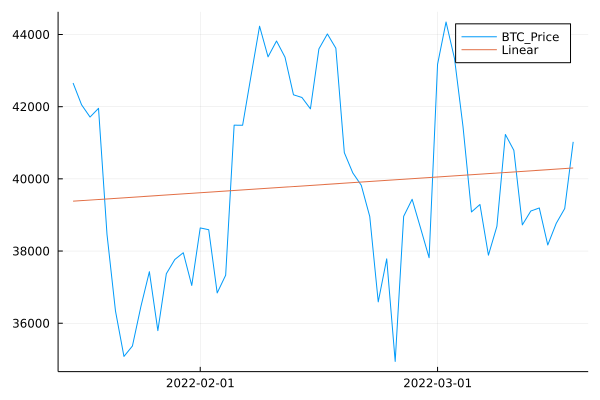

In [9]:
m, b1 = A \ b
pred(x) = m*x + b1
xs = range(1, n)
data = pred.(xs)
plot!(btc_ds.Date, data, label="Linear")

**Polynomial model**

Ahora usaremos un modelo no lineal para ver si se ajusta mejor a los datos, especificamente vamos a usar un polinomio de grado 5
$$f(x) = ax^5 + bx^4 + cx^3 + dx^2 + ex + o$$

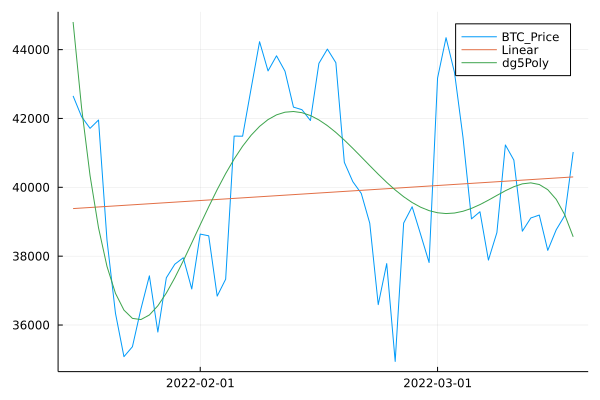

In [10]:
# ax⁵ + bx⁴ + cx³ + dx² + ex + f 
x = Array(1:n)
A = [x.^5 x.^4 x.^3 x.^2 x ones(n)]
a, b, c, d, e, o = A \ b
quint(x) = a*x^5 + b*x^4 + c*x^3 + d*x^2 + e*x + o

xs = range(1, n)
data = quint.(xs)
plot!(btc_ds.Date, data, label="dg5Poly")

Con base en el modelo, ahora podemos predecir el precio del Bitcoin para los proximos 7 dias.

In [11]:
last_date = maximum(btc_ds.Date)
days = [last_date + Dates.Day(i) for i in 1:7]
prediction = quint.(Array(36:42))
[days prediction] 

7×2 Matrix{Any}:
 2022-03-18  42104.5
 2022-03-19  41967.5
 2022-03-20  41769.6
 2022-03-21  41511.2
 2022-03-22  41193.9
 2022-03-23  40821.3
 2022-03-24  40398.6

Ahora vamos a comparar estas predicciones con los datos reales de la ultima semana:

In [12]:
btc_last_week = select(CSV.read("data/BTC_LastWeek.csv", DataFrame), Not(["Unix Timestamp", "Symbol", "Volume"]))
btc_last_week.Date = broadcast(d -> Date(d[1:length(d)-9]), btc_last_week.Date) # parse dates
btc_last_week

,Date,Open,High,Low,Close
,Date,Float64,Float64,Float64,Float64
1,2022-03-24,42754.7,42811.3,42754.7,42801.4
2,2022-03-23,42101.3,43295.2,41777.0,42754.7
3,2022-03-22,42240.3,43360.0,41929.9,42101.3
4,2022-03-21,40861.3,42500.0,40758.2,42240.3
5,2022-03-20,41969.8,42019.1,40529.1,40861.3
6,2022-03-19,41815.9,42400.0,41575.8,41969.8
7,2022-03-18,40555.6,42350.0,40179.7,41815.9


Graficando ambos precios, es apreciable que las predicciones no se desvian demasiado del precio real:

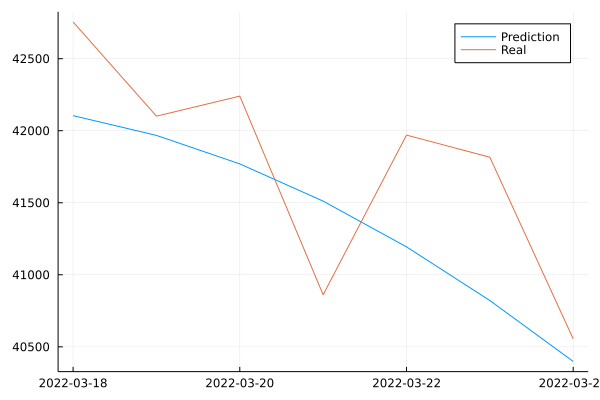

In [13]:
real = btc_last_week.Open
plot(reverse(btc_last_week.Date), [prediction real], labels = ["Prediction" "Real"])

### 3. BTC relationship with other commodities

Ahora vamos a relacionar el precio del bitcoin con el precio de otras materias primas relevantes, especificamente Oro, Plata y Petróleo

Los datos historicos:

- [**Gold**](https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical) in Troy Oz

- [**Silver**](https://www.nasdaq.com/market-activity/commodities/si:cmx/historical) in Troy Oz

- [**Oil**](https://www.nasdaq.com/market-activity/commodities/cl:nmx/historical) WTI Barrel

In [14]:
# load datasets
btc_ds = select(CSV.read("data/Gemini_BTCUSD_day.csv", DataFrame), Not(["Unix Timestamp", "Symbol", "Volume"]))
gold_ds = select(CSV.read("data/GoldUSD_ds.csv", DataFrame), Not(["Volume"]))
silver_ds = select(CSV.read("data/SilverUSD_ds.csv", DataFrame), Not(["Volume"]))
oil_ds = select(CSV.read("data/OilUSD_ds.csv", DataFrame), Not(["Volume"]))
btc_ds = btc_ds[1:251,:] # last year data

str2date(date) = Date(date, dateformat"m/d/y")

# parse dates
btc_ds.Date = broadcast(d -> Date(d[1:length(d)-9]), btc_ds.Date)
gold_ds.Date = str2date.(gold_ds.Date)
silver_ds.Date = str2date.(silver_ds.Date)
oil_ds.Date = str2date.(oil_ds.Date)

# select open prices
btc_price = btc_ds.Open 
gold_price = gold_ds.Open
silver_price = silver_ds.Open
oil_price = oil_ds.Open;

Comparamos el precio del bitcoin con el de las demas materias primas mediante las siguientes graficas.

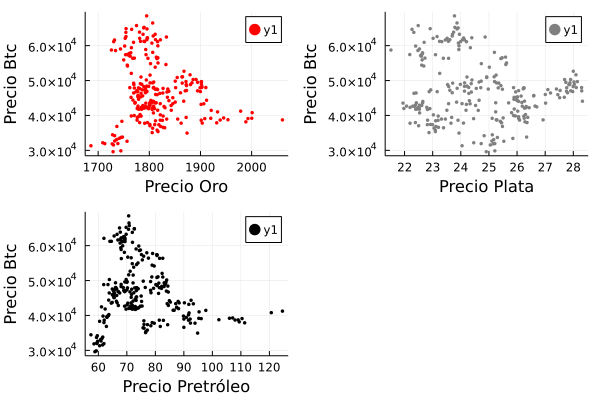

In [15]:
g_plot = plot(gold_price, btc_price,
              seriestype = :scatter,
              markersize = 2,
              markerstrokewidth = 0,
              markercolor = :red,
              xlabel = "Precio Oro",
              ylabel = "Precio Btc") 

s_plot = plot(silver_price, btc_price,
              seriestype = :scatter,
              markersize = 2,
              markerstrokewidth = 0,
              markercolor = :gray, 
              xlabel = "Precio Plata",
              ylabel = "Precio Btc") 

o_plot = plot(oil_price, btc_price,
              seriestype = :scatter,
              markersize = 2,
              markerstrokewidth = 0,
              markercolor = :black, 
              xlabel = "Precio Pretróleo",
              ylabel = "Precio Btc") 

plot(g_plot, s_plot, o_plot)

Podemos ver en las graficas que tanto para el oro como para el petróleo, un precio bajo en la materia prima se relaciona con un precio alto en el bitcoin, esto se podría explicar en el hecho que cuando estas materias tan basicas bajan de precio, los inversionistas buscan otros activos como el bitcoin y por eso su precio tiende a aumentar. En la plata no se ve este comportamiento, posiblemente por que la plata no es tiene tanto valor como el petróleo y el oro. A continuación vamos a intentar modelar estas relaciones:

**Modelo lineal para cada comparación**

La función `gen_PLS` calcula un modelo polinomial de grado `gd` sobre los datos de la materia prima `comm` y bitcoin `btc`.

In [16]:
function gen_PLS(comm, btc, dg)
    n = length(btc)
    A = ones(n,dg+1) # design matrix
    
    for i in 1:dg
        A[1:n, dg+1-i] = comm.^i
    end
    
    x_hat = A \ btc # least squares aproximation
    pol(x) = dot(x_hat, [x^i for i in dg:-1:0]) # polynomial model
    return pol.(comm)
end

gen_PLS (generic function with 1 method)

Graficamos los modelos polinomiales de grado 3 para cada comparación.

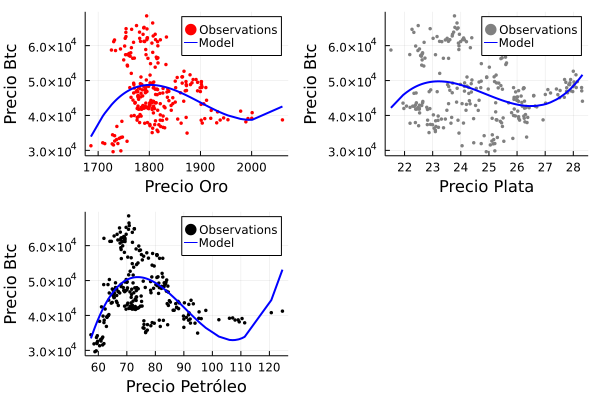

In [17]:
g_plot = plot(gold_price, [btc_price, gen_PLS(gold_price, btc_price, 3)],
              seriestype = [:scatter :line],
              markersize = 2,
              lw = 2,
              linecolor = :blue,
              label = ["Observations" "Model"],
              markerstrokewidth = 0,
              markercolor = :red,
              xlabel = "Precio Oro",
              ylabel = "Precio Btc") 

s_plot = plot(silver_price, [btc_price, gen_PLS(silver_price, btc_price, 3)],
              seriestype = [:scatter :line],
              markersize = 2,
              lw = 2,
              linecolor = :blue,
              label = ["Observations" "Model"],
              markerstrokewidth = 0,
              markercolor = :gray,
              xlabel = "Precio Plata",
              ylabel = "Precio Btc") 

o_plot = plot(oil_price, [btc_price, gen_PLS(oil_price, btc_price, 3)],
              seriestype = [:scatter :line],
              markersize = 2,
              lw = 2,
              linecolor = :blue,
              label = ["Observations" "Model"],
              markerstrokewidth = 0,
              markercolor = :black,
              xlabel = "Precio Petróleo",
              ylabel = "Precio Btc") 

plot(g_plot, s_plot, o_plot)

**Punto extra**

In [345]:
n = 2
x = [[0,0], [1,0], [0,2]]
X = reduce(hcat, x)
y = [[0,0], [-1,0], [0,2]]
Y = reduce(hcat, y)

x_mean = mean(x)
y_mean = mean(y)
x_var = sum(map(x -> norm(x - x_mean)^2, x)) / length(x)

cov_mat = cov(Y, X, dims=2, corrected=false)


U, D, V = svd(cov_mat)

d = sign(det(U)*det(V))
S = Diagonal(append!(ones(n-1), d))

R = U*S*transpose(V) # rotation matrix
c = tr(Diagonal(D)*S)/x_var
t = y_mean - c*R*x_mean;